In [3]:
# K-means分割图像

import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from PIL import Image

def kmeans_image_segmentation(image, n_clusters=2):
    # 将图像转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 将图像数据转换为二维数组
    h, w = gray.shape[:2]
    img_array = gray.reshape((-1, 1))
    
    # 使用KMeans进行聚类
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(img_array)
    
    # 将聚类结果映射回原始图像尺寸
    segmented_image = np.zeros((h, w), dtype=np.uint8)
    for i in range(len(labels)):
        segmented_image[i // w, i % w] = labels[i] * (255 // (n_clusters - 1))
    
    return segmented_image

# 读取图像
image = cv2.imread('../datasets/sample4/bse/100/4-1-1-enhanced-roi.bmp')

plt.imshow(image)
plt.title("raw image")
# 绘制画布
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[ 1, 1])
for i in range(4):
    num = i + 2
    # 使用KMeans进行图像分割
    segmented_image = kmeans_image_segmentation(image, num)

    # 把这个二值图进行保存
    cv2.imwrite(f'../datasets/sample4/bse/100/4-1-1-enhanced-roi-kms{num}.bmp', segmented_image)

    ax = fig.add_subplot(gs[(i // 2) , i % 2])
    ax.imshow(segmented_image)
    ax.set_title("cluster num {}".format(num))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

True

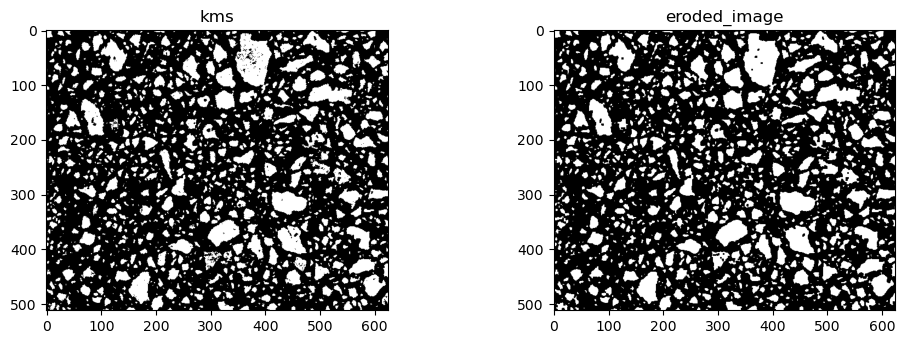

In [4]:
# 对操作进行腐蚀，去掉那些小的颗粒，尽量减少这些细节的干扰
# k-means结果显示，聚类成3类还算正常
# 读取图像

read_path = "../datasets/sample4/bse/100"

kms = cv2.imread('../datasets/sample4/bse/100/4-1-1-enhanced-roi-kms3.bmp', cv2.IMREAD_GRAYSCALE)

gray_cls = 127

neg_cls = kms != gray_cls
positive_cls = kms == gray_cls
kms[neg_cls] = 0
kms[positive_cls] = 255


# 定义核（kernel）的大小
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# 膨胀操作
dilated_image = cv2.dilate(kms, kernel, iterations=1)

# 腐蚀操作
eroded_image = cv2.erode(dilated_image, kernel, iterations=1)



plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1), plt.imshow(kms, cmap='gray',vmin=0, vmax=255), plt.title('kms')
plt.subplot(2, 2, 2), plt.imshow(eroded_image, cmap='gray',vmin=0, vmax=255), plt.title('eroded_image')
# plt.subplot(2, 2, 3), plt.imshow(floated_img, cmap='gray',vmin=0, vmax=255), plt.title('floated')
# plt.subplot(2, 2, 4), plt.imshow(rotated, cmap='gray',vmin=0, vmax=255), plt.title('transform_origin')


cv2.imwrite('../datasets/sample4/bse/100/4-1-1-enhanced-roi-kms3-filter.bmp', eroded_image)




Text(0.5, 1.0, 'raw image')

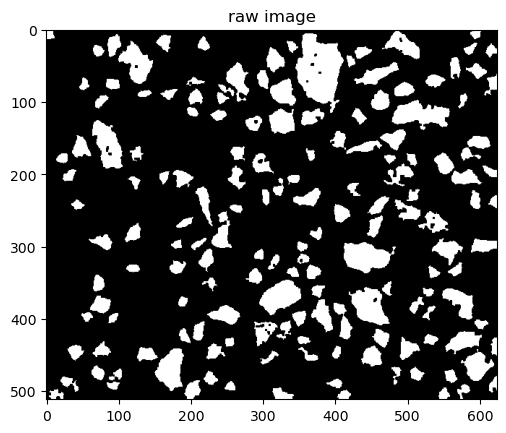

In [5]:
import cv2
import numpy as np

# 读取二值图像
bin_image = cv2.imread(f'{read_path}/4-1-1-enhanced-roi-kms3-filter.bmp', 0)

# 寻找连通区域
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_image, 4, cv2.CV_32S)

# 设置大小阈值
size_threshold = 128

# 创建一个新的图像来存放结果
new_image = np.zeros_like(bin_image)

# 遍历所有连通区域
for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= size_threshold:
        # 如果连通区域的大小大于阈值，则将其添加到新图像中
        new_image[labels == i] = 255

cv2.imwrite(f"{read_path}/4-1-1-masked.bmp", new_image)
# 显示或保存结果
plt.imshow(new_image, cmap="gray", vmin=0, vmax=255)
plt.title("raw image")

In [6]:
# 裁剪BSE增强图像以及二值图像
bse_img = Image.fromarray(image)
masked_img = Image.fromarray(new_image)

start_left = 270
start_top = 0
cropped_width = 256
cropped_height = 256
rect = (start_left, start_top, start_left+cropped_width, start_top+cropped_height)

cropped_bse_img = bse_img.crop(rect)
cropped_masked_img = masked_img.crop(rect)

cropped_bse_img.save(f"{read_path}/4-1-1-matched-bse.bmp", format="BMP")
cropped_masked_img.save(f"{read_path}/4-1-1-matched-masked.bmp", format="BMP")

In [19]:
masked_img = np.array([
    [0, 255, 255],
    [0, 0, 255]

])

img1 = np.array([
    [1, 80, 12],
    [0, 0, 90]

])
img2 = np.array([
    [1, 100, 30],
    [0, 0, 100]

])


# 带遮罩的空间信息
def spatial_correlation_with_mask(img1, img2):
    bound = [0, 50]
    lower_bound = bound[0]
    upper_bound = bound[1]
    img1_after_masked = img1 & masked_img
    img2_after_masked = img2 & masked_img
    diff_imgs = np.abs(img1_after_masked - img2_after_masked)
    res = (diff_imgs > lower_bound) & (diff_imgs <= upper_bound)
    count = np.sum(res)
    return count

spatial_correlation_with_mask(img1, img2)

[[False  True  True]
 [False False  True]]


3